In [1]:
import numpy as np
import matplotlib
import sys, platform, os
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import camb

from camb import model, initialpower

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

from PolAngle import *
from beam import * 
from map import *
from convolution import * 
from beam_class import *

# POWER SPECTRA

In [2]:
#Set up a new set of parameters for CAMB
pars = camb.CAMBparams()
#This function sets up with one massive neutrino and helium set using BBN consistency
pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122, mnu=0.06, omk=0, tau=0.06)
pars.InitPower.set_params(As=2e-9, ns=0.965, r=0.001)
pars.set_for_lmax(2500, lens_potential_accuracy=0)
pars.WantTensors= True

In [3]:
#calculate results for these parameters
results = camb.get_results(pars)

In [4]:
#get dictionary of CAMB power spectra
powers = results.get_cmb_power_spectra(pars, CMB_unit='muK')
for name in powers: print(name)

total
unlensed_scalar
unlensed_total
lensed_scalar
tensor
lens_potential


(2551, 4)


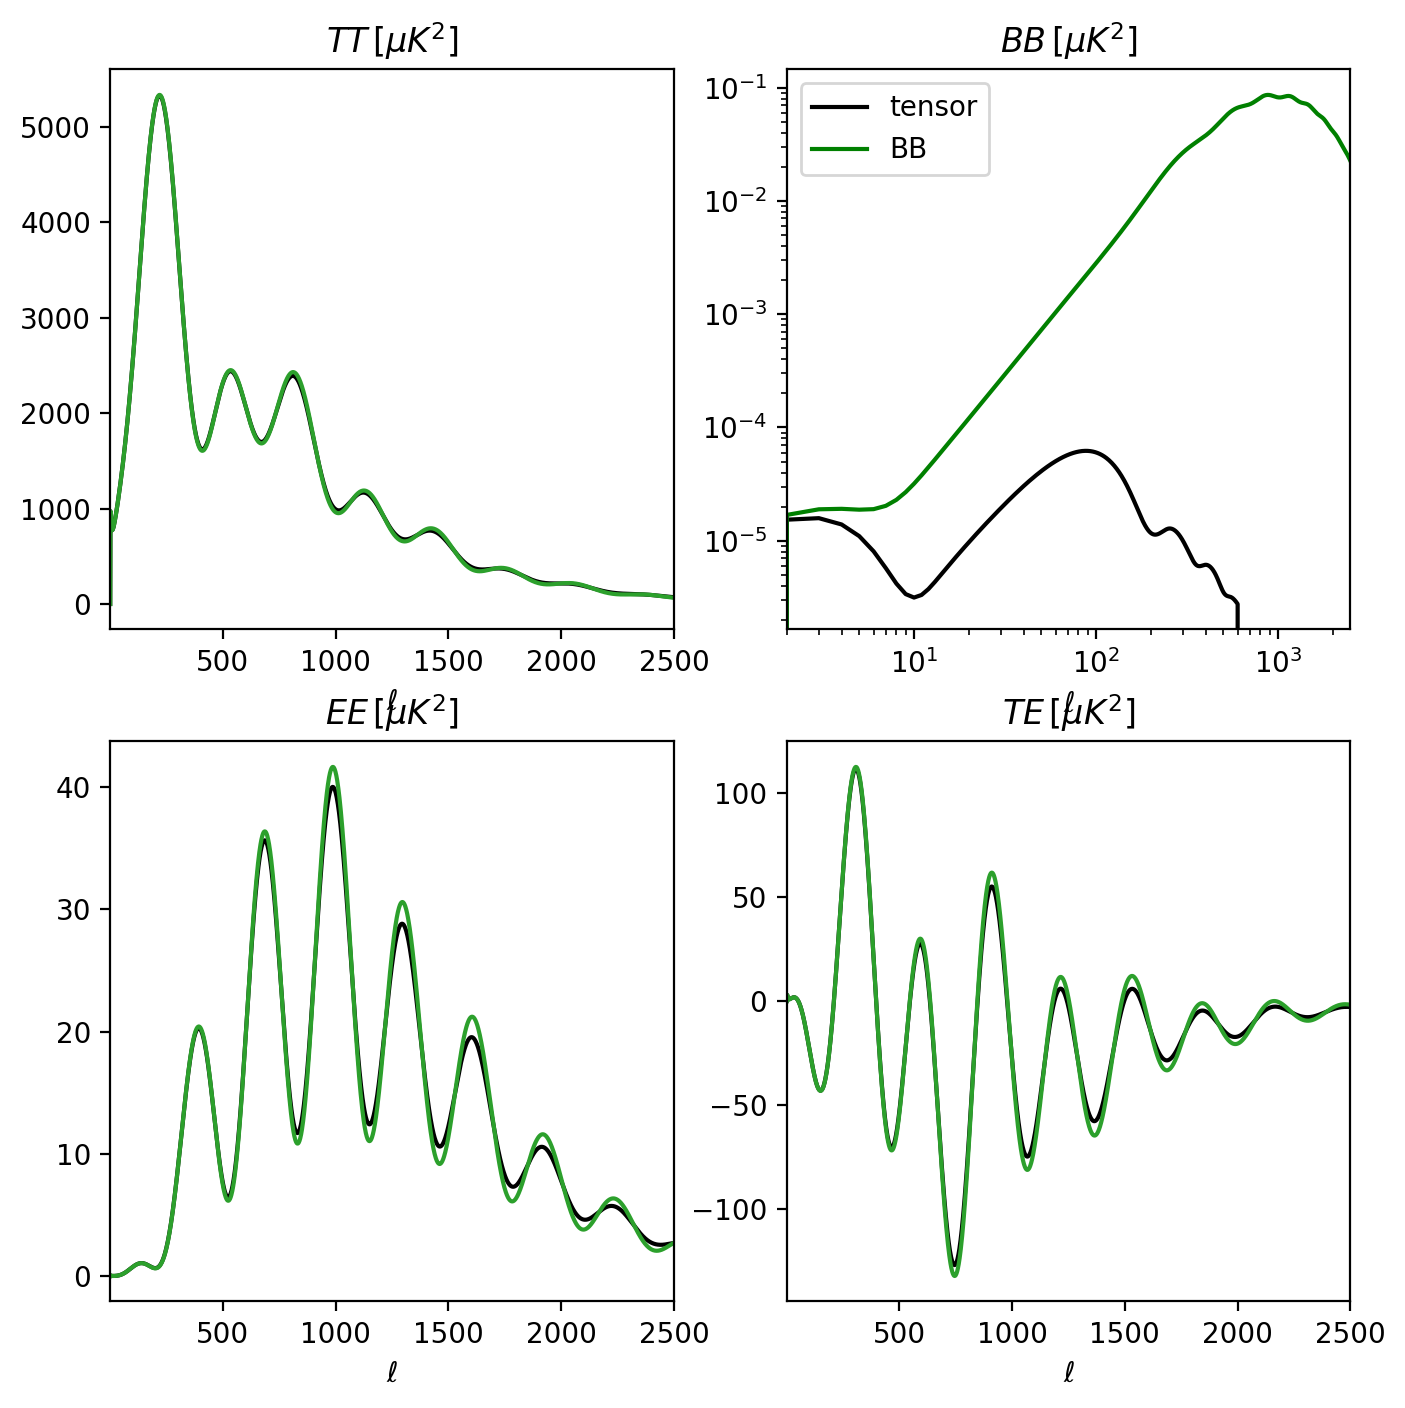

In [5]:
#plot the total lensed CMB power spectra versus unlensed, and fractional difference
totCL = powers['total']
unlensedCL = powers['unlensed_scalar']
tensor = powers['tensor']
print(totCL.shape)

ls = np.arange(totCL.shape[0])
fig, ax = plt.subplots(2,2, figsize = (8,8))

# TT
ax[0,0].plot(ls,totCL[:,0], color='k')
ax[0,0].plot(ls,unlensedCL[:,0], color='C2')
ax[0,0].set_title(r'$TT\, [\mu K^2]$')

#EE
ax[1,0].plot(ls,totCL[:,1], color='k')
ax[1,0].plot(ls,unlensedCL[:,1], color='C2')
ax[1,0].set_title(r'$EE\, [\mu K^2]$')

#BB
ax[0,1].loglog(ls,tensor[:,2], color='k', label="tensor")
ax[0,1].loglog(ls,totCL[:,2], color='g', label="BB")
ax[0,1].set_title(r'$BB\, [\mu K^2]$')
ax[0,1].legend()

# TE
ax[1,1].plot(ls,totCL[:,3], color='k')
ax[1,1].plot(ls,unlensedCL[:,3], color='C2')
ax[1,1].set_title(r'$TE\, [\mu K^2]$')

for ax in ax.reshape(-1): 
    ax.set_xlim([2,2500])
    ax.set_xlabel(r'$\ell$')

In [6]:
# rinomino per comodità
TT_ps  = totCL[:,0] 
TE_ps  = totCL[:,3] 
EE_ps  = totCL[:,1] 
BB_ps  = totCL[:,2]
BB_ps_tensor  = tensor[:,2]

### Salvataggio PS

In [7]:
np.savetxt('Original_PS_001.txt', np.vstack((TT_ps, TE_ps, EE_ps, BB_ps, BB_ps_tensor)), fmt='%8f')

### Uso i notebook PolAngle_PS e PolAngle_Map per generare le mappe/PS perturbati, poi torno qui per confrontare i risultati

# IMMAGINI

In [8]:
# LEGGO DATI DA PERTURBAZIONE DEI PS


# Mappe perturbate
Maps_PSpert = np.loadtxt('Maps_PSpert_001.txt')

#PS perturbati
PS_PSpert   = np.loadtxt('EB_PS_PSpert_001.txt')


# Assegno nuove matrici
matrix_rows = Maps_PSpert.shape[0] // 4  # 4 matrices stacked vertically
Maps_PSpert = Maps_PSpert.reshape(4, matrix_rows, -1)

Emap_PSpert, Bmap_PSpert, Qmap_PSpert, Umap_PSpert = Maps_PSpert

# Assegno nuovi PS
EPS_PSpert  = PS_PSpert[0]
BPS_PSpert  = PS_PSpert[1]

In [9]:
# LEGGO DATI DA PERTURBAZIONE DELLE MAPPE

# Mappe perturbate
Maps_MAPSpert = np.loadtxt('Maps_MAPSpert_001.txt')


#PS perturbati
PS_MAPSpert   = np.loadtxt('EB_PS_MAPSpert_001.txt')


# Assegno nuove matrici
#matrix_rows   = Maps_MAPSpert.shape[0] // 4  # 4 matrices stacked vertically
Maps_MAPSpert = Maps_MAPSpert.reshape(4, matrix_rows, -1)

Emap_MAPSpert, Bmap_MAPSpert, Qmap_MAPSpert, Umap_MAPSpert = Maps_MAPSpert

# Assegno nuovi PS
EPS_MAPSpert  = PS_MAPSpert[0]
BPS_MAPSpert  = PS_MAPSpert[1]

In [10]:
# parametri mappa

pix_size = 0.5    #arcmin
N        = 2**10  #num pixel lineare
X_width, Y_width = N*pix_size/60., N*pix_size/60.   #dimensioni mappa in gradi

c_min, c_max     = -200, 200                        #color map

#se voglio invece partire da una dimensione fissata di mappa e pixel, uso questa formula per trovare quanti pixel mi servono
#N = (X_width * 60)/ pix_size #pixel number

print(f"Mappa con {N} x {N} pixels, ognuno di {pix_size} arcmin, per una dimensione totale di {X_width:.2f} x {Y_width:.2f} gradi")


nbig = 5000

Mappa con 1024 x 1024 pixels, ognuno di 0.5 arcmin, per una dimensione totale di 8.53 x 8.53 gradi


### Confronto mappe perturbate nei due modi

In [11]:
map_list = [Emap_PSpert, Bmap_PSpert, Qmap_PSpert, Umap_PSpert, Emap_MAPSpert, Bmap_MAPSpert, Qmap_MAPSpert, Umap_MAPSpert]
title_list = ["E_PSpert", "B_PSpert", "Q_PSpert", "U_PSpert", "E_MAPSpert", "B_MAPSpert", "Q_MAPSpert", "U_MAPSpert"]

In [12]:
'''
def Plot_CMB_Map_compact(ax, Map_to_Plot, c_min, c_max, X_width, Y_width):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    im = ax.imshow(Map_to_Plot, interpolation='bilinear', origin='lower', cmap='RdBu_r')
    im.set_clim(c_min, c_max)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax)
    im.set_extent([0, X_width, 0, Y_width])
    ax.set_ylabel('angle $[^\circ]$')
    ax.set_xlabel('angle $[^\circ]$')
    cbar.set_label('temperature [uK]', rotation=270)
'''

'\ndef Plot_CMB_Map_compact(ax, Map_to_Plot, c_min, c_max, X_width, Y_width):\n    from mpl_toolkits.axes_grid1 import make_axes_locatable\n    im = ax.imshow(Map_to_Plot, interpolation=\'bilinear\', origin=\'lower\', cmap=\'RdBu_r\')\n    im.set_clim(c_min, c_max)\n    divider = make_axes_locatable(ax)\n    cax = divider.append_axes("right", size="5%", pad=0.05)\n    cbar = plt.colorbar(im, cax=cax)\n    im.set_extent([0, X_width, 0, Y_width])\n    ax.set_ylabel(\'angle $[^\\circ]$\')\n    ax.set_xlabel(\'angle $[^\\circ]$\')\n    cbar.set_label(\'temperature [uK]\', rotation=270)\n'

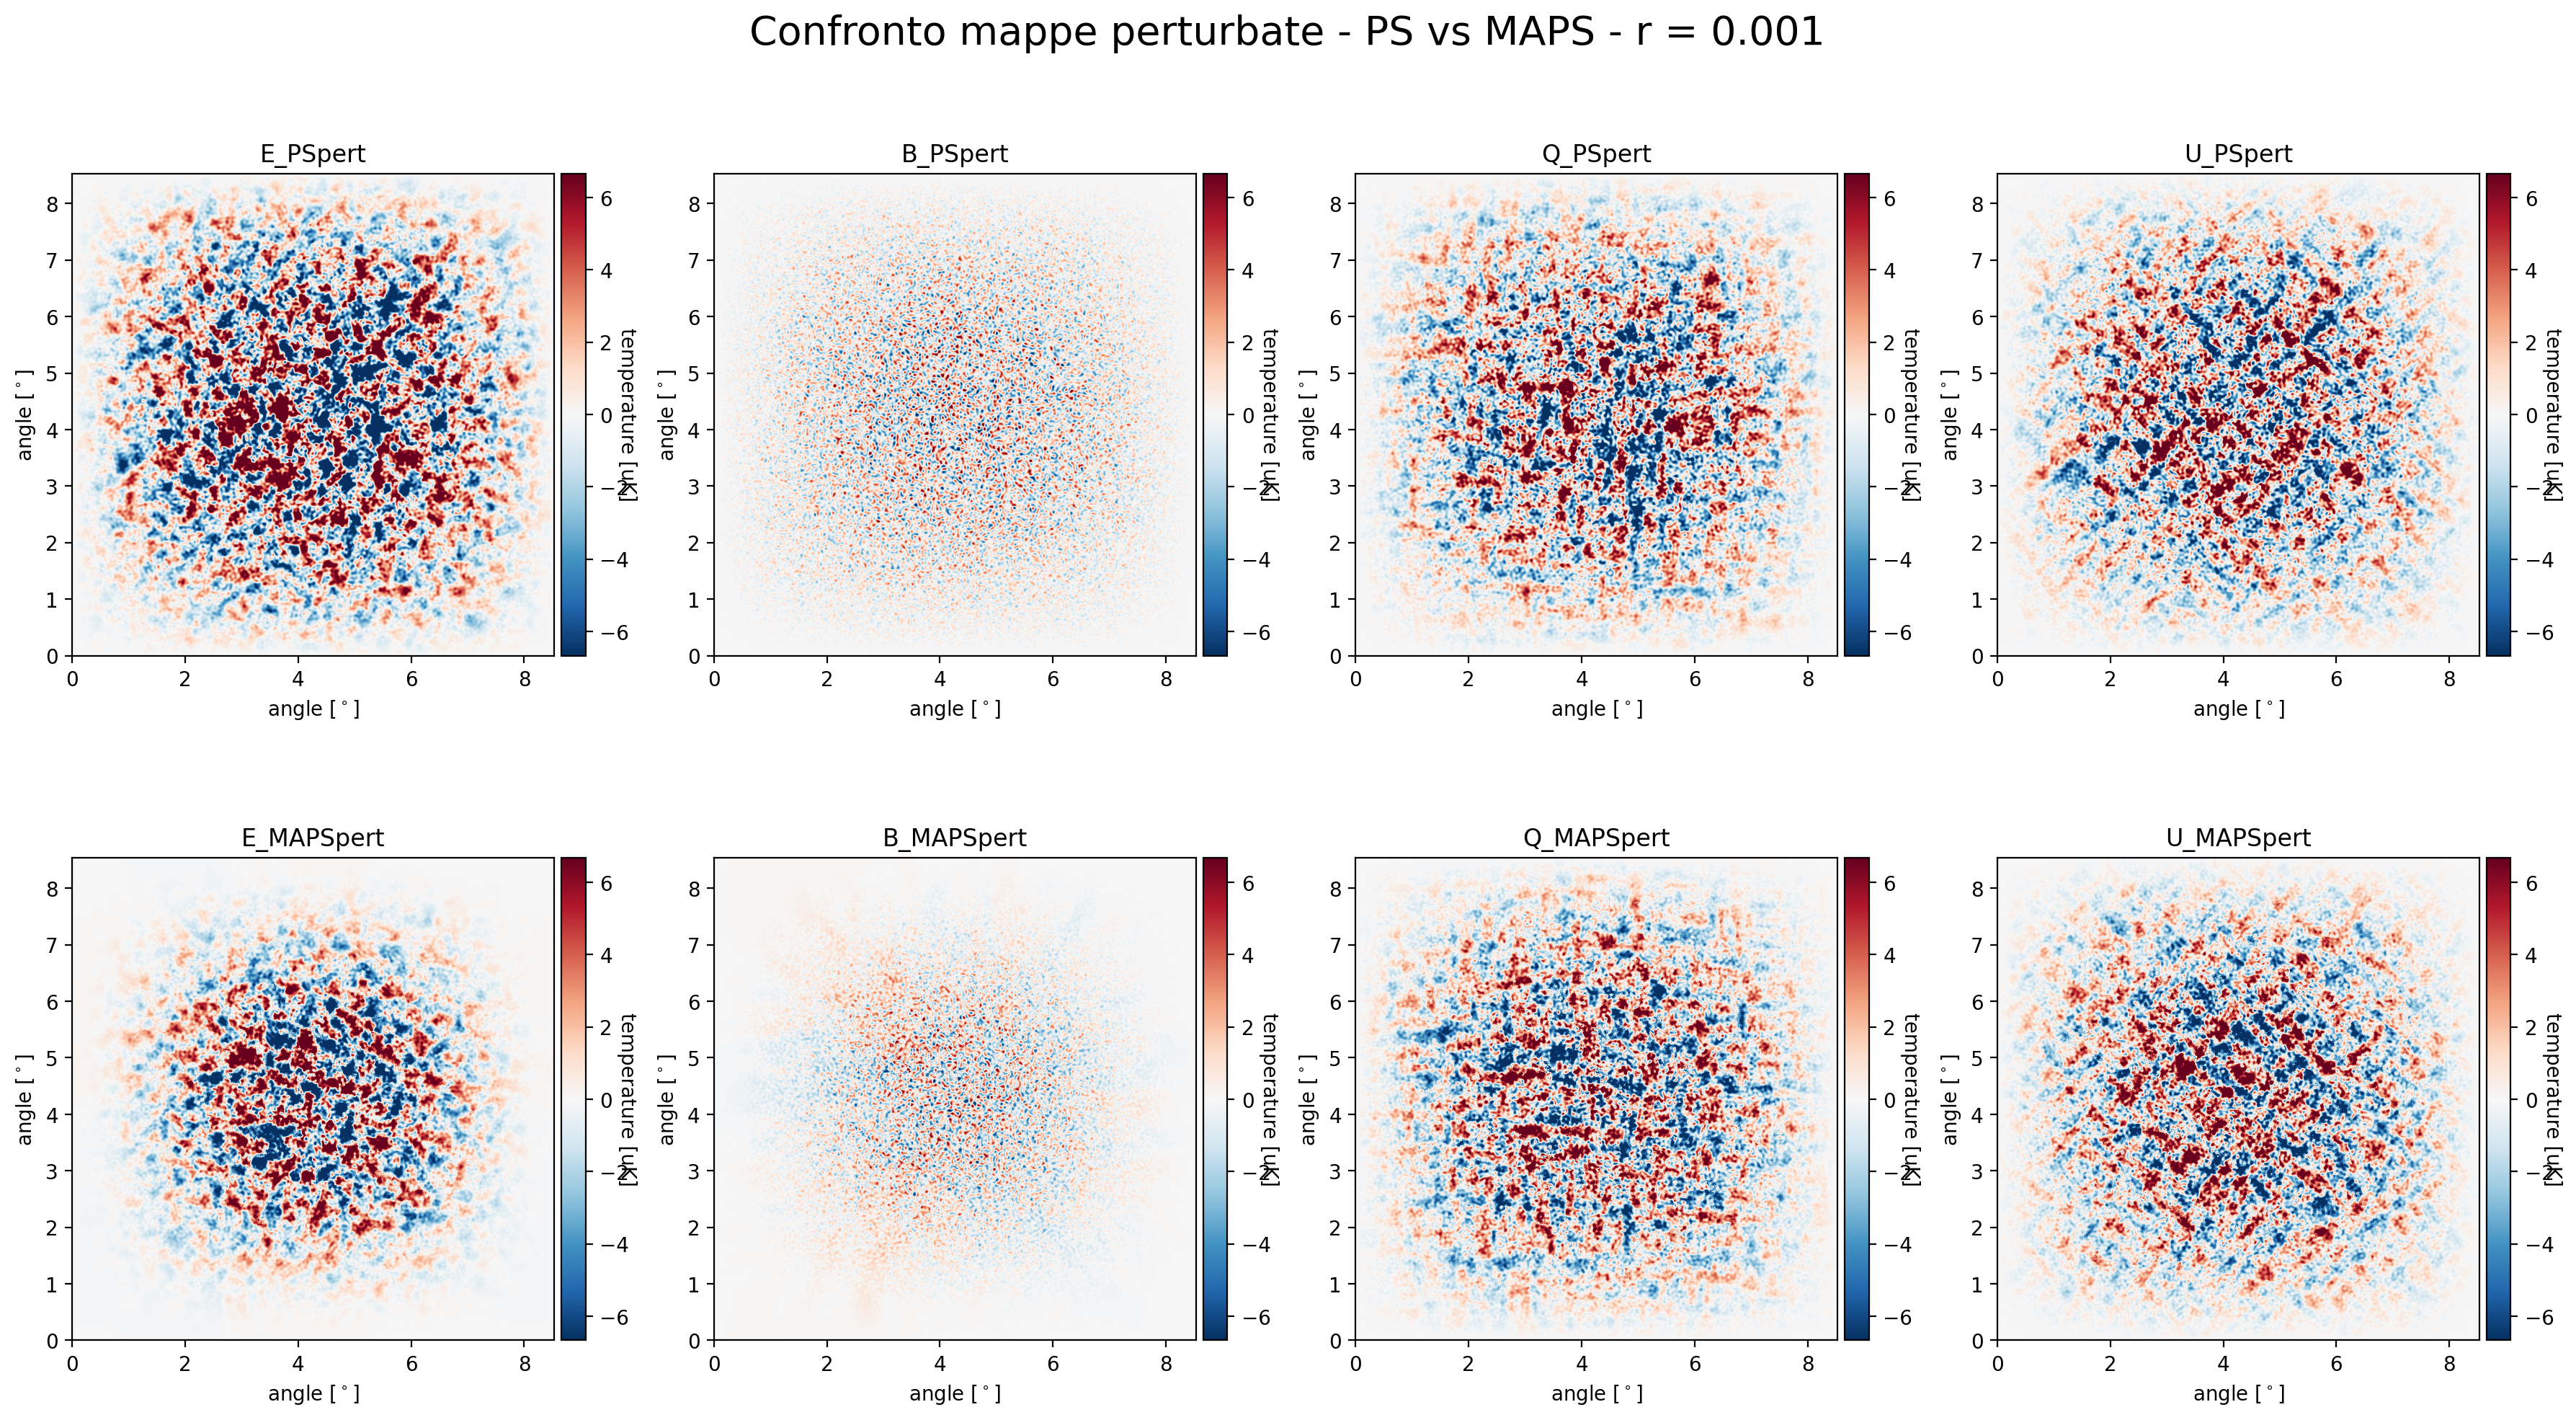

In [13]:
fig, axs = plt.subplots(2, 4, figsize=(18, 10))
axs      = axs.flatten()


for i, map_data in enumerate(map_list):

        Plot_CMB_Map_compact(axs[i], map_data, c_min/30, c_max/30, X_width, Y_width)
        axs[i].set_title(title_list[i])
        
        
plt.tight_layout()
plt.subplots_adjust(wspace=0.25, hspace=0.2, top=0.90)
plt.suptitle('Confronto mappe perturbate - PS vs MAPS - r = 0.001', fontsize=20)
plt.savefig('C:/Users/guide/Documents/University/TESI/immagini/Maps_PSvsMAPS_001.png')  
plt.show()

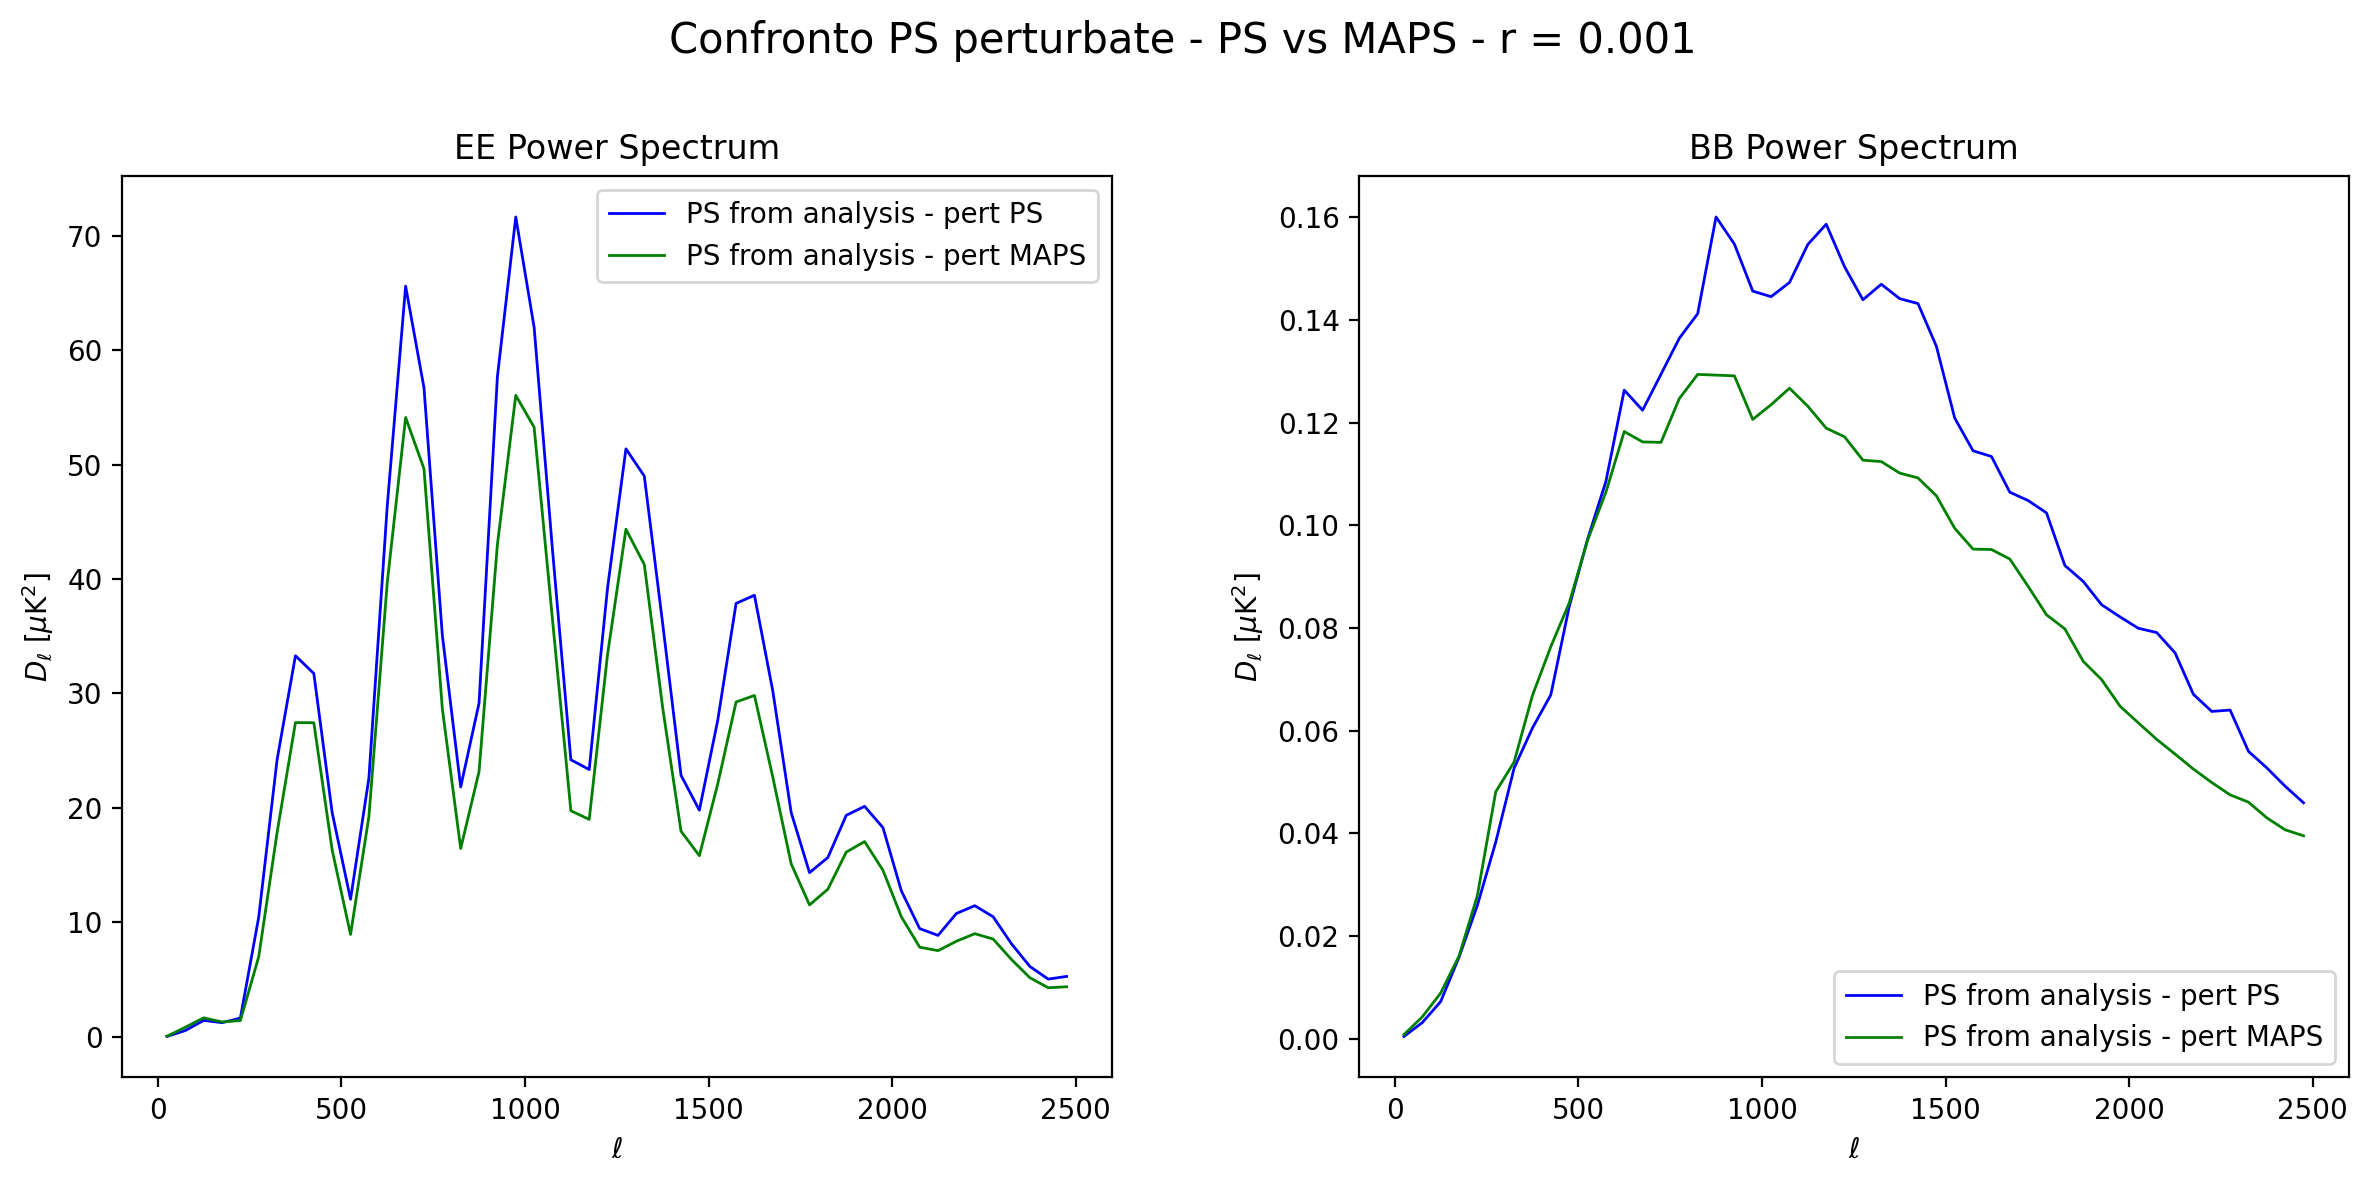

In [14]:
binned_l = [25,75,125,175,225,275,325,375,425,475,525,575,625,675,725,775,825,875,925,975,1025,1075,1125,1175,1225,1275,1325,1375
,1425, 1475, 1525, 1575, 1625, 1675, 1725, 1775, 1825, 1875, 1925, 1975, 2025, 2075, 2125, 2175, 2225, 2275, 2325, 2375, 2425, 2475]

fig, ax = plt.subplots(1, 2, figsize=(12, 6))  

EPS_PSpert
ax[0].plot(binned_l,EPS_PSpert,color='blue', label="PS from analysis - pert PS", linewidth=1)
ax[0].plot(binned_l,EPS_MAPSpert,color='green', label="PS from analysis - pert MAPS", linewidth=1)

ax[0].set_title("EE Power Spectrum")
ax[0].set_ylabel('$D_{\ell}$ [$\mu$K$^2$]')
ax[0].set_xlabel('$\ell$')
ax[0].legend()

#

ax[1].plot(binned_l,BPS_PSpert,color='blue', label="PS from analysis - pert PS", linewidth=1)
ax[1].plot(binned_l,BPS_MAPSpert,color='green', label="PS from analysis - pert MAPS", linewidth=1)

ax[1].set_title("BB Power Spectrum")
ax[1].set_ylabel('$D_{\ell}$ [$\mu$K$^2$]')
ax[1].set_xlabel('$\ell$')
ax[1].legend()

#

plt.tight_layout()
plt.subplots_adjust(wspace=0.25, hspace=0.2, top=0.85)
plt.suptitle('Confronto PS perturbate - PS vs MAPS - r = 0.001', fontsize=15)
plt.savefig('C:/Users/guide/Documents/University/TESI/immagini/PS_PSvsMAPS_001.png')  
plt.show()